# MSDM5003 Assignment5A
__name__: LIU Jingting

In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

## Q1.1
`TeacherNetwork` is the class of teacher network, with `scipy.special.erf()` as the activation function. When an object of this class is initialized, weights of hidden units are drawn from the normal distribution `N(0, 1/N)`.

In [2]:
class TeacherNetwork():
    def __init__(self, inp_dim=1000, num_hidden_units=3):
        self.inp_dim = inp_dim
        self.num_hidden_units = num_hidden_units
        self.weights = np.random.normal(0, np.sqrt(1 / inp_dim), (num_hidden_units, inp_dim))   # 3*1000
        self.activation = sp.erf
        
    def forward(self, x):
        self.field = np.dot(self.weights, x)  # 3*1
        self.g = self.activation(self.field / np.sqrt(2))   # 3*1
        sigma = np.sum(self.g)    
        return sigma
    
    def calc_overlap(self):
        t = np.dot(self.weights, self.weights.T)  # 3*3
        return t

Here an instance of `TeacherNetwork` is initialized and the teacher network run one time to yield the output:

In [6]:
teacher = TeacherNetwork()
inp = np.random.normal(0, 1, 1000)
output = teacher.forward(inp)
output

0.620342474895934

## Q1.2
The overlap matrix of the teacher network's weights is calculated by taking the outer product of weight vector, which is close to $\delta_{nm}$.

In [8]:
overlap = teacher.calc_overlap()
np.round(overlap, 3)

array([[ 0.952,  0.02 ,  0.047],
       [ 0.02 ,  1.01 , -0.03 ],
       [ 0.047, -0.03 ,  0.99 ]])

## Q1.2, 1.3
Class `StudentNetwork` is defined as follows, the method `backward()` updates the weights according to gradients.

In [3]:
class StudentNetwork():
    def __init__(self, inp_dim=1000, num_hidden_units=3):
        self.inp_dim = inp_dim
        self.num_hidden_units = num_hidden_units
        self.weights = np.random.normal(0, np.sqrt(1 / inp_dim), (num_hidden_units, inp_dim))   # 3*1000
        self.activation = sp.erf
        
    def forward(self, x):
        self.field = np.dot(self.weights, x)  # 3*1
        self.g = self.activation(self.field / np.sqrt(2))   # 3*1
        sigma = np.sum(self.g)    
        return sigma
    
    def backward(self, x, y_t, lr):
        g_prime = lambda x:(np.sqrt(2) / np.sqrt(np.pi)) * np.exp(- x**2 / 2) 
        delta_j = lr * (y_t - np.sum(self.g)) * g_prime(self.field)  # 3*1
        delta_j = np.dot(delta_j, x.T)
        assert self.weights.shape == delta_j.shape   # 3*1000
        self.weights += delta_j
        
    def calc_overlap(self, teacher):
        t = np.dot(self.weights, teacher.weights.T)  # 3*3
        return t

## Q1.4
Function `online_learning()` takes vector $\xi$ and student and teacher network instances as its input, performs calculation on $\xi$ using the two networks and update the weights of student using gradient.

In [4]:
def online_learning(student, teacher, x, eta=0.01, dim=1000):
    y_t = teacher.forward(x)
    y_s = student.forward(x)
    student.backward(x, y_t, eta / dim)
    return y_t, y_s

Then we run the online learning algorithm for $\alpha=300$ time units, with $N=1000$ steps in each unit. We store the matrices $\mathbf{Q}$ and $\mathbf{R}$ in separate lists so that we can visit them later.

In [ ]:
alpha = 300
N = 1000
num_examples = 30
s = StudentNetwork()
t = TeacherNetwork()
Qs, Rs = list(), list()

In [27]:
for a in range(alpha):
    for _ in range(N):
        for _ in range(num_examples):
            x = np.random.randn(N, 1)
            online_learning(s, t, x, eta=0.1)
    Q = np.dot(s.weights, s.weights.T)
    R = s.calc_overlap(t)
    Qs.append(Q)
    Rs.append(R)

We can also try with a smaller eta:

In [33]:
s = StudentNetwork()
t = TeacherNetwork()
Qs1, Rs1 = list(), list()
for a in range(alpha):
    for _ in range(N):
        for _ in range(num_examples):
            x = np.random.randn(N, 1)
            online_learning(s, t, x, eta=0.01)
    Q1 = np.dot(s.weights, s.weights.T)
    R1 = s.calc_overlap(t)
    Qs1.append(Q1)
    Rs1.append(R1)

## Q1.5
`plot_curve()` plots the value of $\mathbf{R_{nm}}$ as follows. We can see that as time elapses, the values of $\mathbf{R_{nm}}$ increases and then converges.

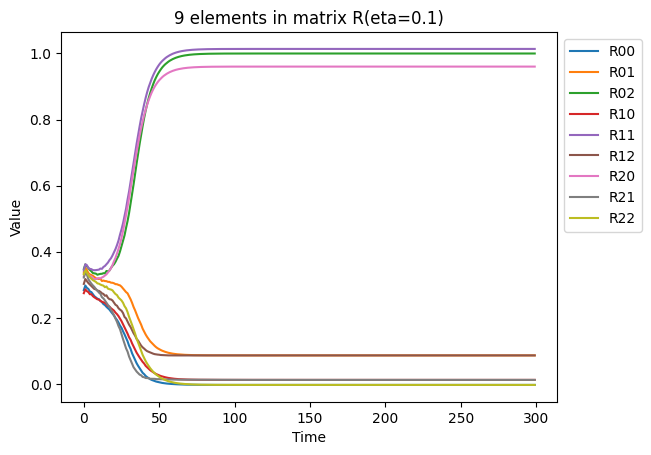

In [30]:
def plot_curve(data, eta=0.1):
    transposed = list(zip(*data))    # transpose the list of lists to get elements of same index
    for idx, column in enumerate(transposed):    # plot each column as a separate curve
        plt.plot(column, label=f"R{idx//3}{idx%3}")  

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"9 elements in matrix R(eta={eta})")
    plt.legend(loc='upper left',  bbox_to_anchor=(1, 1))
    plt.show()

data = list()
for r in Rs:
    data.append(r.flatten().tolist())
plot_curve(data)

Plot when eta takes the value 0.01. We can see that the plots agree with what we learned in class.

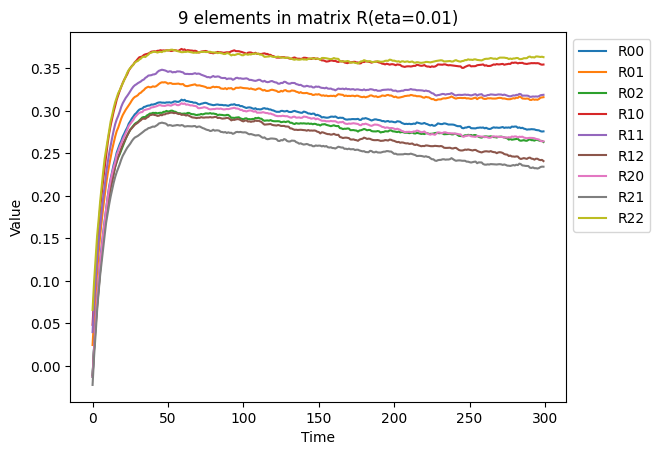

In [36]:
data1 = list()
for r in Rs1:
    data1.append(r.flatten().tolist())
plot_curve(data1, eta=0.01)

## Q1.6
`compute_generalization_error()` takes the outputs of teacher and student networks and compute the generalization error as stated in problem description. 

In [8]:
def compute_generalization_error(teacher, student):
    return (teacher - student)**2 / 2

The change of generalization error in $\alpha=300$ time units is as computed and plotted below, from now on __eta takes the value 0.1.__

In [14]:
s1 = StudentNetwork()
t1 = TeacherNetwork()
gen_err = list()

for a in range(alpha):
    err = 0
    for step in range(N):
        for _ in range(num_examples):
            x = np.random.rand(1000, 1)
            y_t, y_s = online_learning(s1, t1, x)
            err += compute_generalization_error(y_t, y_s)
    gen_err.append(err / (N * num_examples))

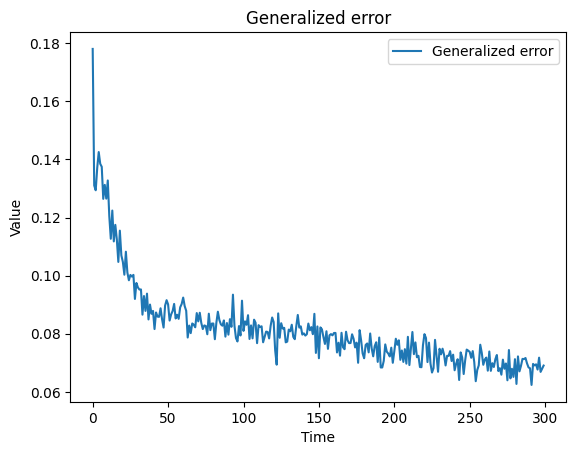

In [15]:
def plot_error(data):
    fig = plt.figure()
    
    plt.plot(data, label='Generalized error')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Generalized error')
    plt.legend(loc='upper right')
    plt.show()
    return

plot_error(gen_err)

## Q1.7
The comparison between real and theoretical generalization error is as shown below.

In [ ]:
def compute_theoretical_error(Q, T, R):
    ns = Q.shape[0]
    nt = T.shape[0]
    err = 0
    for i in range(ns):
        for k in range(ns):
            err += np.arcsin(Q[i, k] / (np.sqrt(1 + Q[i, i]) * np.sqrt(1 + Q[k, k])))
            
    for i in range(nt):
        for k in range(nt):
            err += np.arcsin(T[i, k] / (np.sqrt(1 + T[i, i]) * np.sqrt(1 + T[k, k])))
            
    for i in range(ns):
        for k in range(nt):
            err -= 2 * np.arcsin(R[i, k] / (np.sqrt(1 + Q[i, i]) * np.sqrt(1 + T[k, k])))
    
    return err / np.pi
    
    

real_err, theo_err = np.zeros(alpha), np.zeros(alpha)
s2 = StudentNetwork()
t2 = TeacherNetwork()
T = t2.calc_overlap()
    
for a in range(alpha):
    x = np.random.rand(1000, 1000)  # 1000 samples
    for _ in range(N):
        for row in x:
            inp = row[:, np.newaxis]  # 1000 * 1
            y_t, y_s = online_learning(s2, t2, inp)
            Q = np.dot(s2.weights, s2.weights.T)
            R = s2.calc_overlap(t2)
            real_err[a] += compute_generalization_error(y_t, y_s)
            theo_err[a] += compute_theoretical_error(Q, T, R)
            
real_err /= N * 1000
theo_err /= N * 1000

Unfortunately, however, there is something wrong with the computation of theoretical error since it cannot converge, and I failed to figure out where the problem lies.

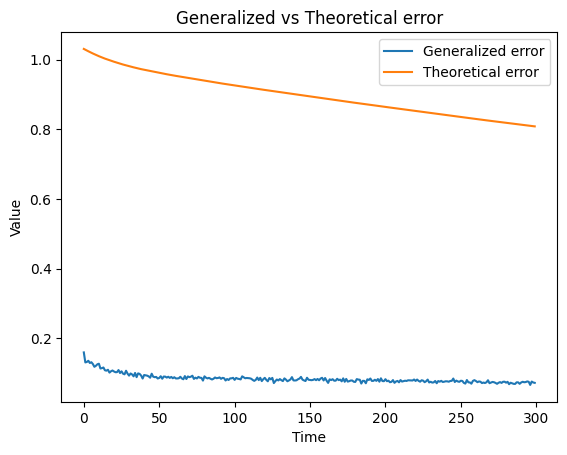

In [17]:
def plot_errors(reality, theory):
    fig = plt.figure()
    
    plt.plot(reality, label='Generalized error')
    plt.plot(theory, label='Theoretical error')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Generalized vs Theoretical error')
    plt.legend(loc='upper right')
    plt.show()
    return

plot_errors(real_err.tolist(), theo_err.tolist())